## Анализ роста Charge
Подходит для анализа роста на данных с небольшой девиацией.<br>
Анализ выполняется с помощью поиска min, max, std значений

In [2]:
import pyodbc
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Download data from OCS DB

start_date = '2018-12-03 00:00:00'
end_date = '2018-12-07 00:00:00'

#Connect to OCSDBREP1 (BSS)
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER=172.18.11.82;DATABASE=10028;UID=BSS;PWD=iKQVm40AZAmyRaw72LeY')

sql_srt=\
'''
select CONVERT(VARCHAR(8), u.usage_date, 3) as 'REP_DATE'
,u.mcc,u.mnc,uc.account_id,u.usage_type
,sum(u.quantity) as quantity,sum(uc.charge) as charge,sum(uc.cost) as cost
from [10028_usage2018-12].[dbo].[USAGE] u
inner join [10028_usage2018-12].[dbo].[USAGE_CHARGES] uc
on u.USAGE_ID = uc.USAGE_ID
where u.usage_date >= 
''' + "'" + start_date + "' and u.usage_date < '" + end_date + "' " +\
'''
GROUP BY CONVERT(VARCHAR(8), u.usage_date, 3),u.mcc,u.mnc,uc.account_id,u.usage_type
ORDER BY u.mcc,CONVERT(VARCHAR(8), u.usage_date, 3)
'''

df = pd.read_sql_query(sql_srt, cnxn, parse_dates={'REP_DATE': '%d/%m/%y'})
cnxn.close()

df['account_id']=df['account_id'].astype(int)

df.head()

,REP_DATE,mcc,mnc,account_id,usage_type,quantity,charge,cost
0,2018-12-03,202,5,352342,1,75.26668,5.71276,3.30423
1,2018-12-03,202,5,352342,21,50.00000,0.00000,0.00000
2,2018-12-03,202,5,352342,33,3926.35184,28.44643,16.49062
3,2018-12-03,202,5,352399,33,2035.37630,12.82286,8.54858
4,2018-12-03,202,5,352583,33,147.72156,NaN,NaN


In [4]:
# Prepare functions

def f(df_x):
    if df_x['charge','mean']==0:
        df_x['std_per']=0
    else:
        df_x['std_per']=round(df_x['charge','std']*100/df_x['charge','mean'],1)
    df_x['diff']=round(df_x['charge','max']-df_x['charge','min'],1)
    return df_x

### By country

In [20]:
# Find out the country with the biggest increase

df1=df.groupby(['REP_DATE','mcc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                     std_per   diff
        sum    min     mean     max         std               
mcc                                                           
208  3537.9  464.0  884.475  1276.6  419.560209    47.4  812.6
730  1602.2  137.5  400.550   749.1  301.828268    75.4  611.6
204  2033.9  312.8  508.475   801.5  219.163978    43.1  488.7
232  1211.6  174.5  302.900   607.2  204.945570    67.7  432.7
460  2570.1  449.3  642.525   763.8  149.959936    23.3  314.5

                quantity   cost  charge
REP_DATE   mcc                         
2018-12-03 460   14788.3  368.9   763.8
2018-12-04 460   11015.1  264.5   449.3
2018-12-05 460   10798.6  350.2   598.4
2018-12-06 460   14856.1  448.9   758.6 



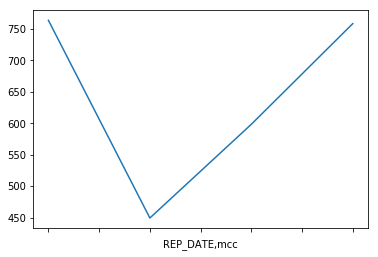

In [25]:
# Generate stat report by country

mcc = 460

df3=df1[df1.index.get_level_values('mcc')==mcc].sort_index(level=['mcc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By operator

In [13]:
# Find out the operator with the biggest increase

df1=df.groupby(['REP_DATE','mcc','mnc']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head(10)

charge                                       std_per   diff
            sum     min      mean     max         std               
mcc mnc                                                             
730 2    1602.2   137.5   400.550   749.1  301.828268    75.4  611.6
232 3     738.1    42.3   184.525   551.3  245.016549   132.8  509.0
204 98    923.6    64.6   230.900   553.3  218.971003    94.8  488.7
208 10    736.7    28.3   184.175   509.8  221.304773   120.2  481.5
    29    733.2    58.0   183.300   458.9  187.889418   102.5  400.9
    20   1769.5   269.6   442.375   644.1  174.359731    39.4  374.5
530 1    1688.7   286.6   422.175   590.4  143.467032    34.0  303.8
216 30    304.0     0.8    76.000   300.4  149.600468   196.8  299.6
460 6    1922.6   326.0   480.650   622.4  121.649044    25.3  296.4
655 1    6023.1  1360.7  1505.775  1628.3  110.713485     7.4  267.6

                    quantity   cost  charge
REP_DATE   mcc mnc                         
2018-12-03 208 29     4036.0   43.0    69.7
2018-12-04 208 29     3266.8   38.5    58.0
2018-12-05 208 29     8042.6   96.4   146.6
2018-12-06 208 29    18487.3  300.8   458.9 



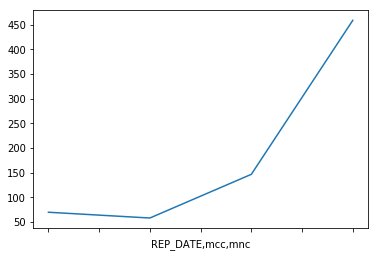

In [9]:
# Generate stat report by country

mcc = 208
mnc = 29

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

### By customer

In [14]:
# Find out the customer with the biggest increase in Country

df1=df.groupby(['REP_DATE','mcc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                    std_per   diff
                   sum    min     mean    max         std               
mcc account_id                                                          
204 352342      1229.7  131.5  307.425  654.7  235.961824    76.8  523.2
232 352342       983.3   96.5  245.825  601.3  238.096302    96.9  504.8
208 352342      1235.9  146.8  308.975  634.3  228.719135    74.0  487.5
216 352342       497.5   47.7  124.375  349.9  150.354678   120.9  302.2
460 352342      2251.0  422.7  562.750  709.6  118.505766    21.1  286.9

In [10]:
# Find out the customer with the biggest increase in Country and Operator

df1=df.groupby(['REP_DATE','mcc','mnc','account_id']).agg({'quantity':np.sum,'cost':np.sum,'charge':np.sum}).copy()
df1['quantity']=round(df1['quantity'],1)
df1['charge']=round(df1['charge'],1)
df1['cost']=round(df1['cost'],1)

df2=df1.groupby(level=['mcc','mnc','account_id']).agg({'charge':[np.sum,'min','mean','max','std']}).copy()

# Two options of sorting

#df2.apply(f,axis=1).sort_values(by=[('charge','sum'),'std_per'],ascending=False).head()
df2.apply(f,axis=1).sort_values(by=['diff','std_per'],ascending=False).head()

charge                                    std_per   diff
                       sum    min     mean    max         std               
mcc mnc account_id                                                          
232 3   352342       738.1   42.3  184.525  551.3  245.016549   132.8  509.0
204 98  352342       900.2   64.6  225.050  553.3  222.025291    98.7  488.7
208 10  352342       582.8   26.4  145.700  480.2  223.152235   153.2  453.8
216 30  352342       304.0    0.8   76.000  300.4  149.600468   196.8  299.6
460 6   352342      1922.6  326.0  480.650  622.4  121.649044    25.3  296.4

                           quantity   cost  charge
REP_DATE   mcc account_id                         
2018-12-03 204 352342       11200.2   73.1   131.5
2018-12-04 204 352342       17855.6  116.5   201.7
2018-12-05 204 352342       17147.1  138.9   241.8
2018-12-06 204 352342       23058.9  379.0   654.7 



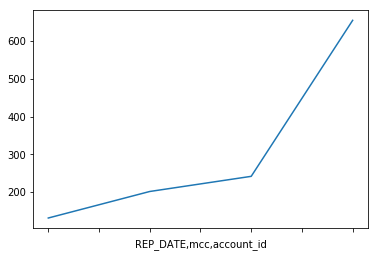

In [17]:
# Generate stat report by country

mcc = 204
account_id = 352342

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()

                               quantity   cost  charge
REP_DATE   mcc mnc account_id                         
2018-12-03 208 29  352342        2937.1   28.5    49.1
2018-12-04 208 29  352342        1539.7   15.6    26.8
2018-12-05 208 29  352342        2850.2   27.4    47.5
2018-12-06 208 29  352342        3185.3  100.6   173.8 



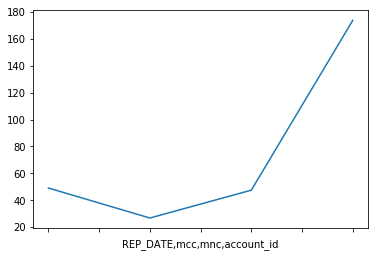

In [12]:
# Generate stat report by country and Operator

mcc = 208
mnc = 29
account_id = 352342

df3=df1[(df1.index.get_level_values('mcc')==mcc) & (df1.index.get_level_values('mnc')==mnc) & (df1.index.get_level_values('account_id')==account_id)]\
      .sort_index(level=['mnc','REP_DATE'])
print(df3,'\n')

df3['charge'].plot()
plt.show()